In [13]:
!pip install scikit-learn
!pip install seaborn



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ----- ------------------------------- 41.0/294.9 kB 667.8 kB/s eta 0:00:01
     ------------------ ------------------- 143.4/294.9 kB 1.4 MB/s eta 0:00:01
     ------------------------------------ - 286.7/294.9 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
!pip install kneed



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
!pip install pyodbc


     ---------------------------------------- 0.0/68.9 kB ? eta -:--:--
     ----------------- ---------------------- 30.7/68.9 kB ? eta -:--:--
     ---------------------------------------- 68.9/68.9 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sqlalchemy.exc import SQLAlchemyError
from sklearn.preprocessing import StandardScaler


In [ ]:
# Database connection details
DRIVER_NAME = 'ODBC Driver 17 for SQL Server'  
SERVER_NAME = 'LAPTOP-NICOLEE\\SQLEXPRESS01'  
DATABASE_NAME = 'CompanyX'                     

# Connection string for SQLAlchemy
conn_str = (
    f"mssql+pyodbc://@{SERVER_NAME}/{DATABASE_NAME}?driver={DRIVER_NAME}&trusted_connection=yes"
)

# Create engine
engine = create_engine(conn_str)

# Test the connection
try:
    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print("Error connecting to the database:", e)


Connection successful!


In [25]:
# SQL query to fetch data
query = """
SELECT 
    p.Productname,
    p.ProductID,
    p.Category,
    f.Revenue,
    f.ROI,
    f.NetProfitMargin
FROM 
    Fact f
JOIN 
    DimProduct p ON f.ProductID = p.ProductID
"""

# Load data into a pandas DataFrame
data = pd.read_sql(query, engine)
print("Data loaded successfully.")

Data loaded successfully.


In [26]:
# Drop rows with missing values and check for duplicates
data = data.dropna().drop_duplicates()

In [27]:
# Function to preprocess data
def preprocess_category(data, category_name):
    category_data = data[data['Category'] == category_name].copy()
    if category_data.empty:
        print(f"Warning: No data found for category '{category_name}'. Skipping.")
        return None, None, None

    # Feature selection
    features = category_data[['Revenue', 'ROI', 'NetProfitMargin']].copy()

    # Outlier detection: Filter rows with extreme values
    revenue_threshold = features['Revenue'].quantile(0.99)  # 99th percentile
    features_filtered = features[features['Revenue'] < revenue_threshold]

    # Synchronize category_data to match filtered features
    category_data = category_data.loc[features_filtered.index]

    # Scaling using MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_filtered)

    return category_data, features_scaled, scaler

In [28]:
def find_optimal_clusters(features, max_clusters=15):
    # Scale the features for better clustering
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    inertia = []
    silhouette_scores = []
    
    # Calculate inertia and silhouette scores
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_features)
        inertia.append(kmeans.inertia_)
        silhouette = silhouette_score(scaled_features, labels)
        silhouette_scores.append(silhouette)
    
    # Find knee point for optimal K
    kneedle = KneeLocator(range(2, max_clusters + 1), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee

    # Plot Elbow Curve and Silhouette Scores
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow Curve
    ax[0].plot(range(2, max_clusters + 1), inertia, 'o--', label='Inertia')
    ax[0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
    ax[0].set_title('Elbow Method')
    ax[0].set_xlabel('Number of Clusters')
    ax[0].set_ylabel('Inertia')
    ax[0].legend()

    # Silhouette Scores
    ax[1].plot(range(2, max_clusters + 1), silhouette_scores, 'o--', color='green', label='Silhouette Score')
    ax[1].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
    ax[1].set_title('Silhouette Scores for Clusters')
    ax[1].set_xlabel('Number of Clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].legend()

    plt.show()
    
    return optimal_k

In [29]:
# Perform clustering and visualize
def perform_clustering(data, category_name, n_clusters=None):
    category_data, features_scaled, scaler = preprocess_category(data, category_name)
    if category_data is None or features_scaled is None:
        return None

    # Determine number of clusters if not provided
    if n_clusters is None:
        n_clusters = find_optimal_clusters(features_scaled)
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    category_data['Cluster'] = kmeans.fit_predict(features_scaled)

    # Retrieve centroids
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=category_data, x='Revenue', y='ROI', 
                    hue='Cluster', palette='viridis', s=100)
    
    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], 
                c='red', s=300, marker='X', label='Centroids')
    plt.title(f'Clustering Results for {category_name} Category')
    plt.xlabel('Revenue')
    plt.ylabel('Return on Investment')
    plt.legend(title='Cluster')
    plt.show()
    
    # Display cluster statistics
    cluster_summary = category_data.groupby('Cluster')[['Revenue', 'ROI', 'NetProfitMargin']].mean()
    print(f"Cluster Summary for {category_name}:")
    print(cluster_summary)

    return category_data

In [30]:
def save_to_sql_server(dataframe, table_name, engine):

    try:
        # Fetch existing ProductIDs from the table to avoid duplication
        existing_query = f"SELECT ProductID FROM {table_name}"
        try:
            existing_data = pd.read_sql(existing_query, engine)
            existing_ids = existing_data['ProductID'].unique()
        except Exception as e:
            # Table does not exist, so no existing data
            existing_ids = []

        # Filter out rows that already exist in the table
        new_data = dataframe[~dataframe['ProductID'].isin(existing_ids)]

        if new_data.empty:
            print(f"No new data to save for table '{table_name}'.")
        else:
            # Save new data to SQL Server
            new_data.to_sql(name=table_name, con=engine, if_exists='append', index=False)
            print(f"Successfully saved {len(new_data)} new records to table '{table_name}'.")
    except SQLAlchemyError as e:
        print(f"Error saving data to table '{table_name}': {e}")

In [33]:
# Example: Preprocess the categories and perform clustering   
bikes_data, bikes_features, bikes_scaler = preprocess_category(data, 'Bikes')
clothing_data, clothing_features, clothing_scaler = preprocess_category(data, 'Clothing')
components_data, components_features, components_scaler = preprocess_category(data, 'Components')
accessories_data, accessories_features, accessories_scaler = preprocess_category(data, 'Accessories')


print("Bike data: ")
print(bikes_data.describe())
print("Clothings data: ")
print(clothing_data.describe())
print("Components data: ")
print(components_data.describe())
print("Accessories data: ")
print(accessories_data.describe())

Bike data: 
         ProductID       Revenue          ROI  NetProfitMargin
count  1034.000000   1034.000000  1034.000000      1034.000000
mean    851.918762   2915.845625    -0.128704        -7.199583
std      96.058233   2734.493462     0.581104        23.397620
min     749.000000    112.998000    -4.222552      -172.764031
25%     776.000000    939.588000    -0.279099        -6.066663
50%     793.000000   1879.176000    -0.096976        -3.600003
75%     965.000000   4079.988000     0.091627         6.266665
max     999.000000  13215.657400     2.587926         9.078667
Clothings data: 
        ProductID     Revenue         ROI  NetProfitMargin
count  210.000000  210.000000  210.000000       210.000000
mean   819.400000  186.937563    0.852198         9.293679
std     69.946131  166.132835    2.362474        31.924466
min    709.000000    5.186500   -9.595960       -45.600825
25%    715.000000   57.680800   -0.437375       -28.333333
50%    859.000000  144.089000    0.519547        3


--- Clustering for Bikes Category ---


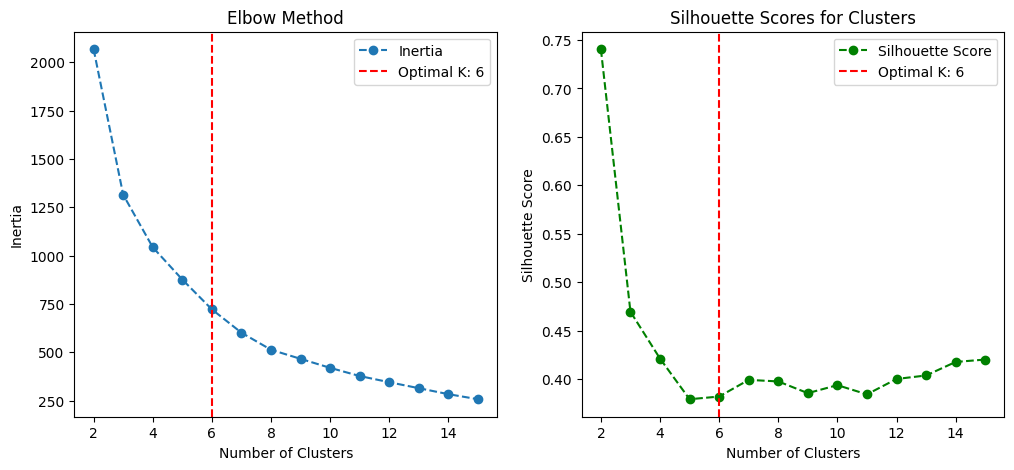

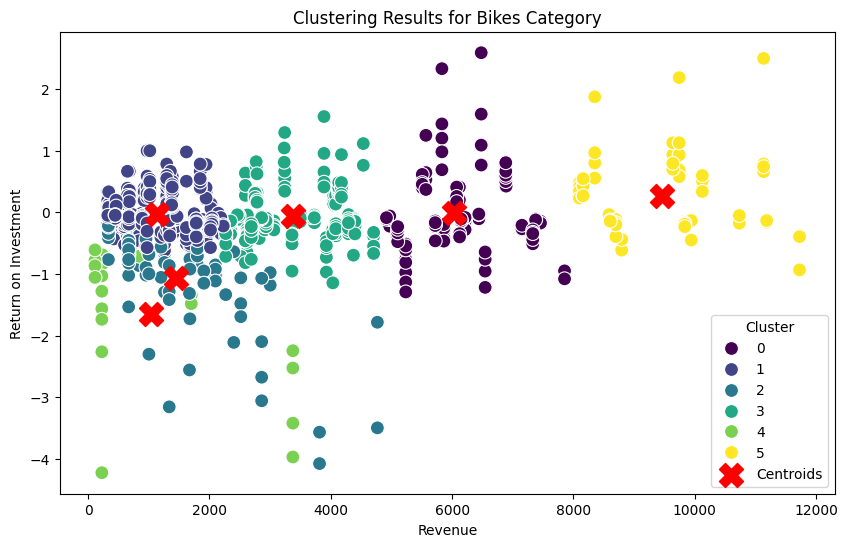

Cluster Summary for Bikes:
             Revenue       ROI  NetProfitMargin
Cluster                                        
0        6032.192693 -0.012688        -2.267674
1        1137.721022 -0.033946        -2.481808
2        1440.527986 -1.068478       -34.859855
3        3372.836279 -0.058017        -1.837421
4        1043.260350 -1.654894      -147.086017
5        9458.587591  0.264451         2.835911


In [34]:
# Find optimal clusters
print(f"\n--- Clustering for Bikes Category ---")
# Apply clustering with a predefined number of clusters 
bikes_clustered_data = perform_clustering(bikes_data,'Bikes')


--- Clustering for Components Category ---


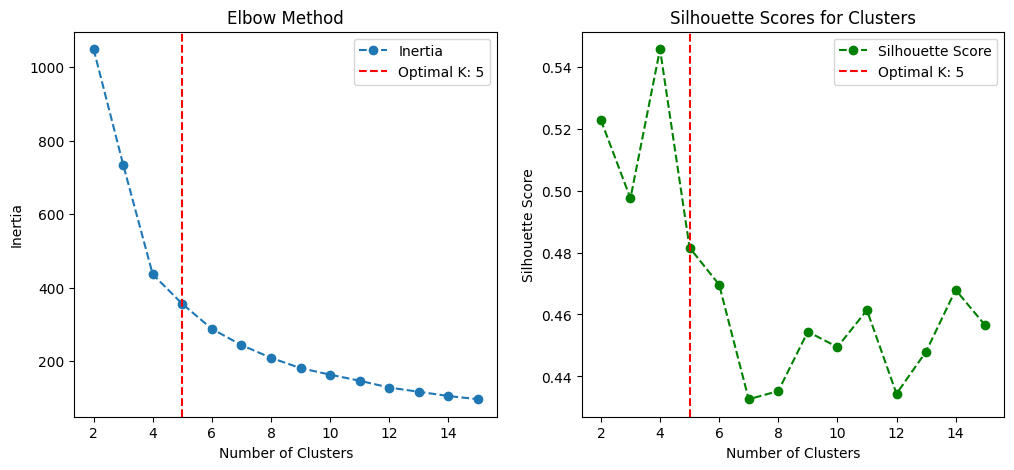

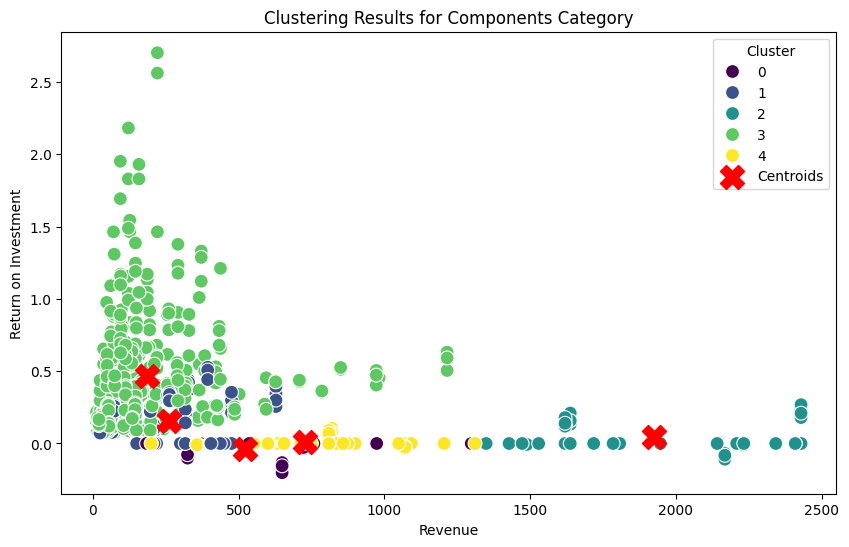

Cluster Summary for Components:
             Revenue       ROI  NetProfitMargin
Cluster                                        
0         521.130484 -0.041350        -8.917476
1         261.416919  0.152883        13.055301
2        1923.533295  0.042719         2.428574
3         183.723707  0.470074        25.999918
4         728.713679  0.007182         3.357840


In [ ]:
print(f"\n--- Clustering for Components Category ---")
# Apply clustering with a predefined number of clusters 
components_clustered_data = perform_clustering(components_data,'Components')


--- Clustering for Clothing Category ---


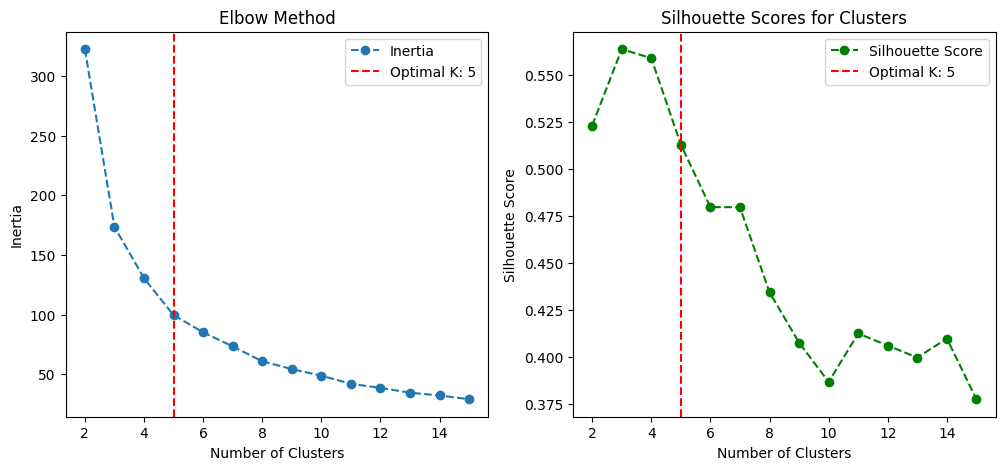

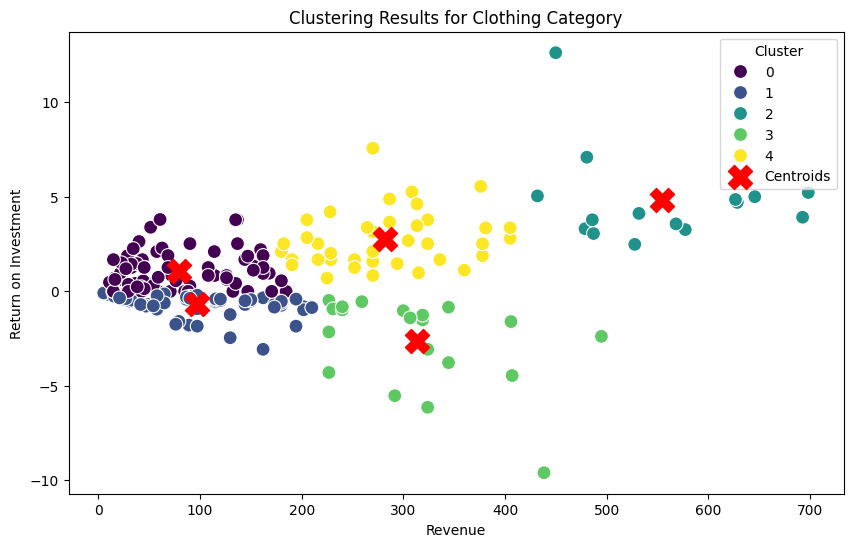

Cluster Summary for Clothing:
            Revenue       ROI  NetProfitMargin
Cluster                                       
0         79.590700  1.065676        35.320458
1         97.144397 -0.664978       -31.445751
2        554.157920  4.807514        29.421187
3        313.458810 -2.636885       -31.208971
4        281.654116  2.746967        32.757874


In [ ]:
print(f"\n--- Clustering for Clothing Category ---")
# Apply clustering with a predefined number of clusters 
clothing_clustered_data = perform_clustering(clothing_data,'Clothing')


--- Clustering for Accessories Category ---


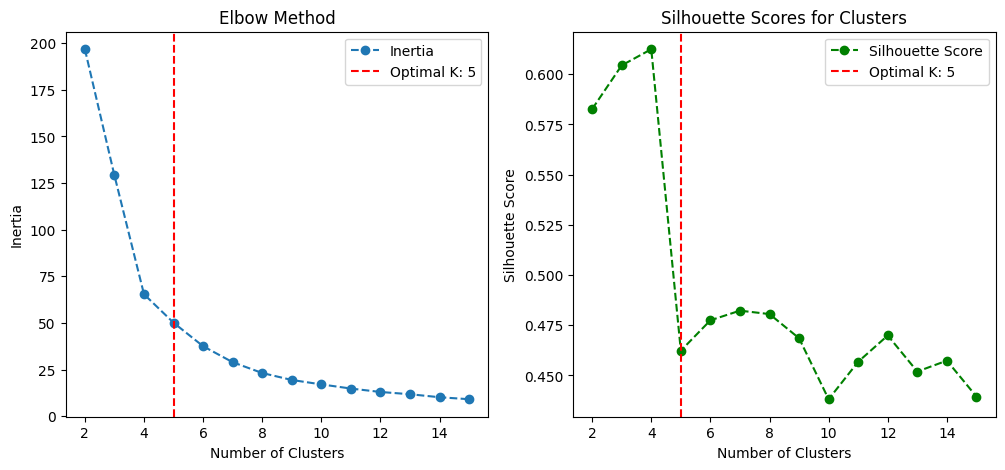

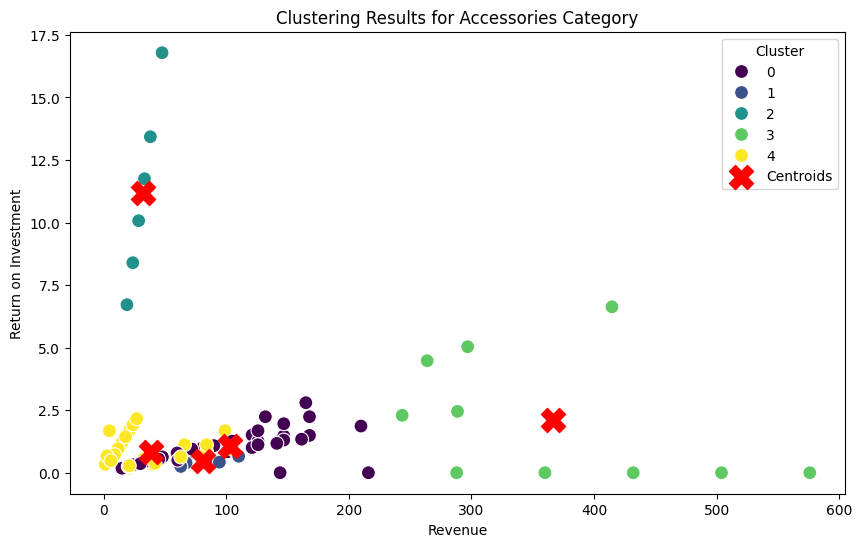

Cluster Summary for Accessories:
            Revenue        ROI  NetProfitMargin
Cluster                                        
0        103.516500   1.052303        34.696477
1         81.060133   0.449740        19.548163
2         31.800000  11.190335        37.666667
3        366.772050   2.088767        36.670038
4         38.336350   0.838383        37.167310


In [ ]:
print(f"\n--- Clustering for Accessories Category ---")
# Apply clustering with a predefined number of clusters 
accessories_clustered_data = perform_clustering(accessories_data,'Accessories')

In [86]:
save_to_sql_server(bikes_clustered_data, 'KMean_Bikes_Clusters', engine)

Successfully saved 1020 new records to table 'KMean_Bikes_Clusters'.


In [87]:
save_to_sql_server(accessories_clustered_data, 'KMean_Accessories_Clusters', engine)

Successfully saved 91 new records to table 'KMean_Accessories_Clusters'.


In [88]:
save_to_sql_server(components_clustered_data, 'KMean_Components_Clusters', engine)

Successfully saved 708 new records to table 'KMean_Components_Clusters'.


In [89]:
save_to_sql_server(clothing_clustered_data, 'KMean_Clothing_Clusters', engine)

Successfully saved 207 new records to table 'KMean_Clothing_Clusters'.
